# Capstone Project - Clustering Municipalities in Brussels
#### Matheus Mafra Oliveira Andrade - Applied Data Science Capstone by IBM/Coursera - 10/2020

## Introduction

Belgium is the 13rd most populous country in Europe and the 11th most developed in the continent. It is also known by its linguistic and cultural diversity, and we cannot forget the Belgian tradition in producing handcrafted beer. Its capital, Brussels, is famous by the cafés, pubs, and bars, where the locals and tourists can spend time with friends and enjoy a good Belgian beer.
With this in mind, an entrepreneur has a dream of opening a new bar in Brussels where he can sell different beers, but he does not know where he should open it. His priority is to avoid strong competition, because he wants to gain trust from clients and a good market share before expanding his business. Thus, he wants to open the bar somewhere distant to other venues which focus on selling beer.
He is now analyzing the municipalities in the city’s metropolitan area and, with the help of Foursquare dataset about places in Brussels, the entrepreneur will cluster the city’s municipalities to check in which of them there are less bars in comparison to other types of venues, and, in other words, the best municipalities to open a new bar.


## Data Description
### In order to complete the enterpreneur’s study, he will need data from three different sources:

A table containing the names of all Brussels’ municipalities, based on data retrieved in 2015 by the Brussels Regional Informatics Centre (CIBG/CIRB). The table can be found on the Wikipedia page: 
https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region;

A table containing the names of venues in Brussels, along with their category, latitude, and longitude;

Coordinates for each municipality, collected in the Python Geopy library.


## Code

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

!pip install beautifulsoup4
from bs4 import BeautifulSoup
import requests
import urllib.request
from bs4 import SoupStrainer
import json
from pandas.io.json import json_normalize

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.



### Parse data from the html (wikipedia page) into a beautifulsoup object

In [2]:
source = 'https://en.wikipedia.org/wiki/List_of_municipalities_of_the_Brussels-Capital_Region'
table_class = 'wikitable sortable jquery-tablesorter'
response = requests.get(source)
soup = BeautifulSoup(response.text, 'html.parser')
brusselstable = soup.find('table',{'class':"wikitable"})

### Create dataframe

In [3]:
df = pd.read_html(str(brusselstable))
df = pd.DataFrame(df[0])
df.head()

,Unnamed: 0,French name,Dutch name,Flag,CoA,postcode,Population(1/1/2017),Area,Population density(km²),Ref.
0,1,Anderlecht,Anderlecht,NaN,NaN,1070,118241,2 (6.8 sq mi),6680,[7]
1,2,Auderghem,Oudergem,NaN,NaN,1160,33313,2 (3.5 sq mi),3701,[8]
2,3,Berchem-Sainte-Agathe,Sint-Agatha-Berchem,NaN,NaN,1082,24701,2 (1.1 sq mi),8518,[9]
3,4,Bruxelles-Ville*,Stad Brussel*,NaN,NaN,1000102011201130,176545,2 (12.6 sq mi),5415,[10]
4,5,Etterbeek,Etterbeek,NaN,NaN,1040,47414,2 (1.2 sq mi),15295,[11]


### Dropping unnecessary columns (Unnamed: 0 is a useless index; Dutch name has the same information as in French name; Flag and CoA are images; postcode won't impact in analysis; Ref is only a hyperlink to each municipality's data source)

In [4]:
df.drop(['Unnamed: 0', 'Dutch name', 'Flag', 'CoA', 'postcode', 'Ref.'], axis = 1, inplace = True)
df.head()

,French name,Population(1/1/2017),Area,Population density(km²)
0,Anderlecht,118241,2 (6.8 sq mi),6680
1,Auderghem,33313,2 (3.5 sq mi),3701
2,Berchem-Sainte-Agathe,24701,2 (1.1 sq mi),8518
3,Bruxelles-Ville*,176545,2 (12.6 sq mi),5415
4,Etterbeek,47414,2 (1.2 sq mi),15295


### Removing unwanted characters from strings (I don't know why, but when I tried to remove all ain the same line it didn't work)


In [5]:
df['French name'] = df['French name'].str.replace(r'*', '')
df['Area'] = df['Area'].str.replace(r'2 ', '')
df['Area'] = df['Area'].str.replace(r'(', '')
df['Area'] = df['Area'].str.replace(r')', '')
df['Area'] = df['Area'].str.replace(r'i', '')
df['Area'] = df['Area'].str.replace(r'm', '')
df['Area'] = df['Area'].str.replace(r' ', '')
df['Area'] = df['Area'].str.replace(r'q', '')
df['Area'] = df['Area'].str.replace(r's', '')
df['Area'] = df['Area'].str.replace(r' ', '')
df.head()

,French name,Population(1/1/2017),Area,Population density(km²)
0,Anderlecht,118241,6.8,6680
1,Auderghem,33313,3.5,3701
2,Berchem-Sainte-Agathe,24701,1.1,8518
3,Bruxelles-Ville,176545,12.6,5415
4,Etterbeek,47414,1.2,15295


### Changing columns names to make the dataframe clearer

In [6]:
df = df.rename(columns={'French name': 'Municipality', 'Population(1/1/2017)': 'Population', 
                        'Population density(km²)': 'Pop density'})
df.head()

,Municipality,Population,Area,Pop density
0,Anderlecht,118241,6.8,6680
1,Auderghem,33313,3.5,3701
2,Berchem-Sainte-Agathe,24701,1.1,8518
3,Bruxelles-Ville,176545,12.6,5415
4,Etterbeek,47414,1.2,15295


### Changing Population, Area and Pop density types to float

In [7]:
df[['Population','Area','Pop density']] = df[['Population','Area','Pop density']].astype(float)
df.dtypes

Municipality     object
Population      float64
Area            float64
Pop density     float64
dtype: object

### Converting the area values to km^2 in order to put them in the same unit as population density

In [8]:
df['Area'] = df['Area'].map(lambda x: x * 2.58998811)
df.head()

,Municipality,Population,Area,Pop density
0,Anderlecht,118241.0,17.611919,6680.0
1,Auderghem,33313.0,9.064958,3701.0
2,Berchem-Sainte-Agathe,24701.0,2.848987,8518.0
3,Bruxelles-Ville,176545.0,32.633850,5415.0
4,Etterbeek,47414.0,3.107986,15295.0


### As you can see, the Population density is innaccurate. So I need to convert it to a more precise value

In [9]:
df['Pop density'] = df['Population'] / df['Area']
df.head()

,Municipality,Population,Area,Pop density
0,Anderlecht,118241.0,17.611919,6713.691961
1,Auderghem,33313.0,9.064958,3674.920345
2,Berchem-Sainte-Agathe,24701.0,2.848987,8670.099472
3,Bruxelles-Ville,176545.0,32.633850,5409.873459
4,Etterbeek,47414.0,3.107986,15255.539790


### Descriptive statistics of the data

In [10]:
df.describe()

,Population,Area,Pop density
count,19.000000,19.000000,19.000000
mean,62716.000000,8.465172,10725.764897
std,42681.784033,8.071577,6365.413739
min,21609.000000,1.035995,1920.549357
25%,30214.000000,2.978486,6061.782710
50%,50471.000000,6.215971,8968.187889
75%,84275.500000,8.935459,15738.349348
max,176545.000000,32.633850,26172.900076


### Box plots of each attributes (green with outliers, red without outliers)

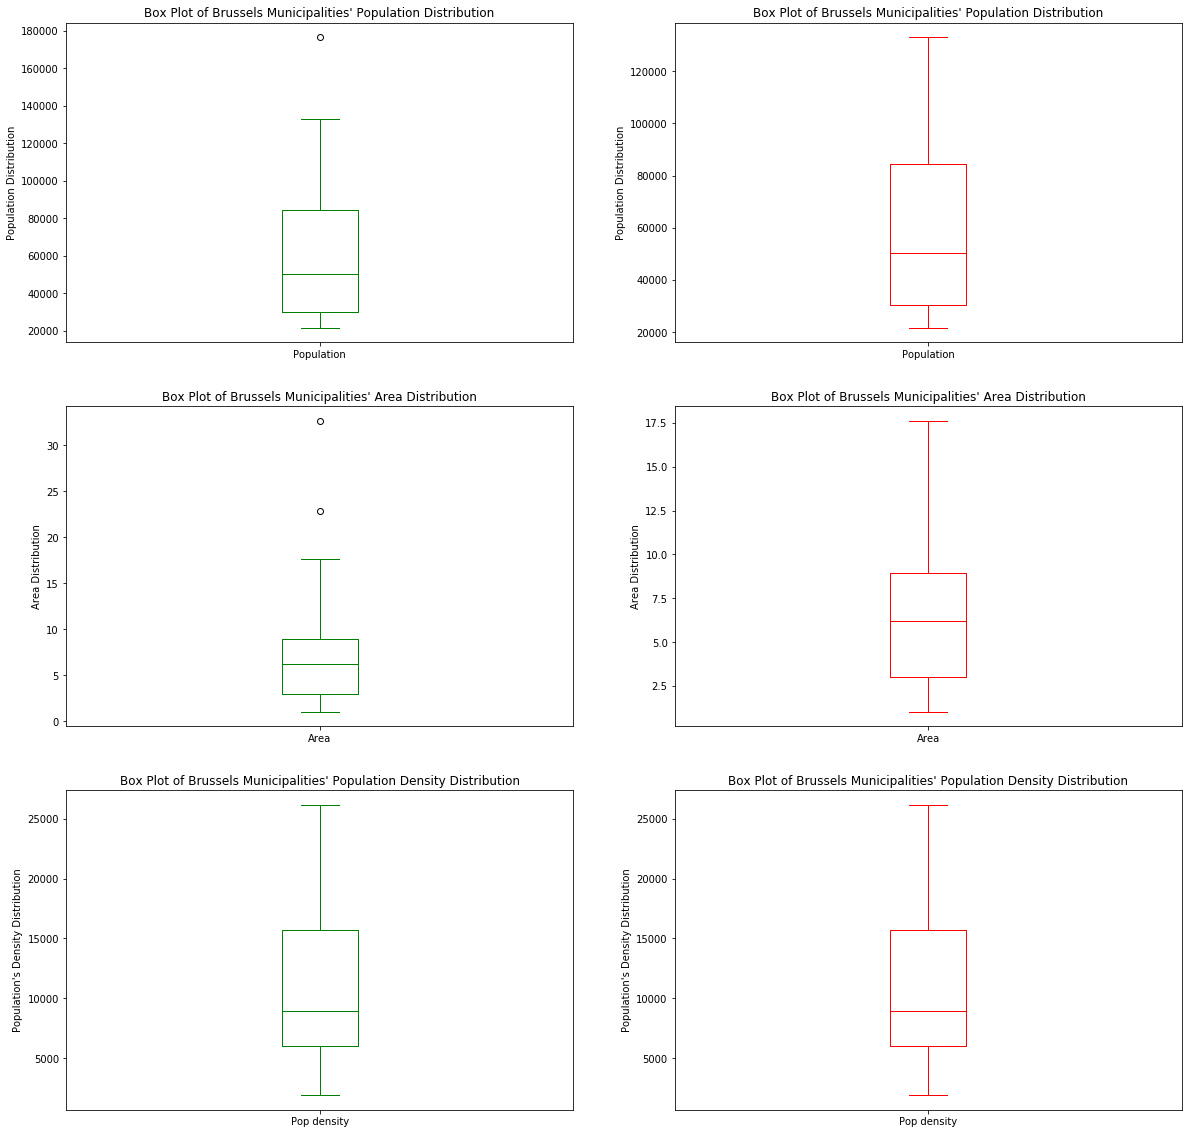

In [11]:
df_pop = df['Population']
df_area = df['Area']
df_den = df['Pop density']
fig = plt.figure()

ax0 = fig.add_subplot(3, 2, 1)
ax1 = fig.add_subplot(3, 2, 2)
ax2 = fig.add_subplot(3, 2, 3)
ax3 = fig.add_subplot(3, 2, 4)
ax4 = fig.add_subplot(3, 2, 5)
ax5 = fig.add_subplot(3, 2, 6)

df_pop.plot(kind='box', color='green', figsize=(20, 20), ax=ax0)
ax0.set_title('Box Plot of Brussels Municipalities\' Population Distribution')
ax0.set_ylabel('Population Distribution')

df_pop.plot(kind='box', color='red', figsize=(20, 20), ax=ax1, showfliers=False)
ax1.set_title('Box Plot of Brussels Municipalities\' Population Distribution')
ax1.set_ylabel('Population Distribution')

df_area.plot(kind='box', color='green', figsize=(20, 20), ax=ax2)
ax2.set_title ('Box Plot of Brussels Municipalities\' Area Distribution')
ax2.set_ylabel('Area Distribution')

df_area.plot(kind='box', color='red', figsize=(20, 20), ax=ax3, showfliers=False)
ax3.set_title ('Box Plot of Brussels Municipalities\' Area Distribution')
ax3.set_ylabel('Area Distribution')

df_den.plot(kind='box', color='green', figsize=(20, 20), ax=ax4)
ax4.set_title('Box Plot of Brussels Municipalities\' Population Density Distribution')
ax4.set_ylabel('Population\'s Density Distribution')

df_den.plot(kind='box', color='red', figsize=(20, 20), ax=ax5, showfliers=False)
ax5.set_title('Box Plot of Brussels Municipalities\' Population Density Distribution')
ax5.set_ylabel('Population\'s Density Distribution')

plt.show()

### Getting geographical coordinates of Brussels

In [12]:
address = 'Brussels, BE'

geolocator = Nominatim(user_agent = 'brussels_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Brussels are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Brussels are 50.8465573, 4.351697.


### Checking nº of rows in dataframe

In [13]:
df.shape

(19, 4)

### Storing each municipalities' coordinates into lists

In [14]:
i = 0
lat = [0]* 19
long = [0]* 19

while i < 19:
    mun_brus = df.iloc[i,0]
    address = mun_brus + ', Brussels'
    geolocator = Nominatim(user_agent = "Brussels_explorer")
    location = geolocator.geocode(address)
    lat[i] = location.latitude
    long[i] = location.longitude
    i += 1

### Appending each municipalities coordinates into the dataframe

In [15]:
df['Latitude'] = lat
df['Longitude'] = long
df

,Municipality,Population,Area,Pop density,Latitude,Longitude
0,Anderlecht,118241.0,17.611919,6713.691961,50.839098,4.329653
1,Auderghem,33313.0,9.064958,3674.920345,50.817236,4.426898
2,Berchem-Sainte-Agathe,24701.0,2.848987,8670.099472,50.864923,4.294673
3,Bruxelles-Ville,176545.0,32.633850,5409.873459,50.846557,4.351697
4,Etterbeek,47414.0,3.107986,15255.539790,50.836145,4.386174
5,Evere,40394.0,4.920977,8208.531892,50.872010,4.403418
6,Forest,55746.0,6.215971,8968.187889,50.846557,4.351697
7,Ganshoren,24596.0,2.589988,9496.568693,50.870327,4.307798
8,Ixelles,86244.0,6.215971,13874.581069,50.833114,4.366828
9,Jette,51933.0,4.920977,10553.391264,50.875959,4.324570


### Creating map of Brussels

In [16]:
map_brussels = folium.Map(location = [latitude, longitude], zoom_start = 12)

# Add markers to the map
for lat, long, name in zip(df['Latitude'], df['Longitude'], df['Municipality']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, long],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_brussels)  
    
map_brussels

### Getting Foursquare API Credentials

In [17]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20201026' # Foursquare API Version

### Defining function to create a dataframe with data about nearby venues for each municipality

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius = 750, LIMIT = 200):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Municipality', 
                  'Municipality_Latitude', 
                  'Municipality_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

### Creating the dataframe

In [20]:
venues = getNearbyVenues(names = df['Municipality'],
                                   latitudes = df['Latitude'],
                                   longitudes = df['Longitude']
                                  )
venues.head()

,Municipality,Municipality_Latitude,Municipality_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Anderlecht,50.839098,4.329653,Chez Rosario,50.836240,4.331007,Deli / Bodega
1,Anderlecht,50.839098,4.329653,Crep' & Cream,50.839050,4.330786,Creperie
2,Anderlecht,50.839098,4.329653,Brasserie Cantillon Brouwerij (Cantillon - Bro...,50.841487,4.335451,Brewery
3,Anderlecht,50.839098,4.329653,Maharaja Tandoori Restaurant I,50.839015,4.332212,Indian Restaurant
4,Anderlecht,50.839098,4.329653,Boeremet,50.842882,4.326992,Cocktail Bar


### Checking how many venues and venue categories were found

In [21]:
print('{} venues found.'.format(venues.shape[0]))
print('{} unique venue categories found.'.format(len(venues['Venue_Category'].unique())))

1313 venues found.
224 unique venue categories found.


### Checking how many venues were found in each municipality

In [22]:
venues.groupby('Municipality').count()['Venue']

Municipality
Anderlecht                86
Auderghem                 65
Berchem-Sainte-Agathe     29
Bruxelles-Ville          100
Etterbeek                100
Evere                     37
Forest                   100
Ganshoren                 41
Ixelles                  100
Jette                     65
Koekelberg                41
Molenbeek-Saint-Jean      73
Saint-Gilles             100
Saint-Josse-ten-Noode    100
Schaerbeek                51
Uccle                     64
Watermael-Boitsfort       37
Woluwe-Saint-Lambert      72
Woluwe-Saint-Pierre       52
Name: Venue, dtype: int64

### Creating a dataframe of categories with one hot encoding 

In [23]:
categories = pd.get_dummies(venues[['Venue_Category']], prefix = "", prefix_sep = "")

categories['Municipality'] = venues['Municipality'] 

venue_columns = list(categories.columns)
venue_columns.remove('Municipality')
fixed_columns = ['Municipality'] + venue_columns
categories = categories[fixed_columns]

categories.head()

,Municipality,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Anderlecht,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dataframe size

In [24]:
categories.shape

(1313, 225)

### Average frequency of each category by municipality

In [25]:
brussels_grouped = categories.groupby('Municipality').mean().reset_index()
brussels_grouped

,Municipality,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Anderlecht,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.023256,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.00,0.000000,0.000000
1,Auderghem,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.015385,0.00000,...,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.00,0.000000,0.000000
2,Berchem-Sainte-Agathe,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.00,0.000000,0.000000
3,Bruxelles-Ville,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.02,0.00000,0.020000,0.000000,0.00,0.000000,0.000000
4,Etterbeek,0.00,0.00,0.01,0.000000,0.010000,0.000000,0.010000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.02,0.00000,0.030000,0.000000,0.00,0.000000,0.000000
5,Evere,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.027027,0.00000,...,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.00,0.000000,0.000000
6,Forest,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.02,0.00000,0.020000,0.000000,0.00,0.000000,0.000000
7,Ganshoren,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.024390,0.000000,0.02439,...,0.000000,0.024390,0.000000,0.00,0.00000,0.000000,0.000000,0.00,0.000000,0.000000
8,Ixelles,0.02,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.020000,0.000000,0.000000,0.00,0.00000,0.040000,0.010000,0.00,0.020000,0.000000
9,Jette,0.00,0.00,0.00,0.015385,0.000000,0.000000,0.015385,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.00,0.000000,0.000000


### Top 5 most common venues by municipality

In [26]:
num_top_venues = 5

for mun in brussels_grouped['Municipality']:
    print("----"+mun+"----")
    temp = brussels_grouped[brussels_grouped['Municipality'] == mun].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Anderlecht----
               venue  freq
0              Hotel  0.10
1        Coffee Shop  0.08
2     Sandwich Place  0.07
3  French Restaurant  0.05
4      Train Station  0.03


----Auderghem----
                  venue  freq
0    Italian Restaurant  0.08
1                Bakery  0.05
2  Fast Food Restaurant  0.05
3     French Restaurant  0.05
4           Pizza Place  0.05


----Berchem-Sainte-Agathe----
              venue  freq
0  Greek Restaurant  0.10
1      Tram Station  0.07
2        Restaurant  0.07
3       Supermarket  0.07
4               Gym  0.07


----Bruxelles-Ville----
             venue  freq
0              Bar  0.10
1         Beer Bar  0.06
2            Plaza  0.04
3   Chocolate Shop  0.04
4  Thai Restaurant  0.04


----Etterbeek----
                venue  freq
0  Italian Restaurant  0.06
1              Bakery  0.05
2      History Museum  0.03
3               Plaza  0.03
4      Sandwich Place  0.03


----Evere----
            venue  freq
0     Supermarket  0.14
1  

### Creating function to sort venues in descending order

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating new dataframe displaying the top 10 venues by municipality

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Municipality']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
municipalities_venues_sorted = pd.DataFrame(columns=columns)
municipalities_venues_sorted['Municipality'] = brussels_grouped['Municipality']

for ind in np.arange(brussels_grouped.shape[0]):
    municipalities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brussels_grouped.iloc[ind, :], num_top_venues)

municipalities_venues_sorted

,Municipality,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,Hotel,Coffee Shop,Sandwich Place,French Restaurant,Bar,Train Station,Food Court,Snack Place,Brewery,Convenience Store
1,Auderghem,Italian Restaurant,Fast Food Restaurant,Pizza Place,French Restaurant,Bakery,Snack Place,Salad Place,Belgian Restaurant,Bar,Metro Station
2,Berchem-Sainte-Agathe,Greek Restaurant,Tram Station,Gym,Restaurant,Bar,Supermarket,Bus Stop,Burger Joint,Notary,Electronics Store
3,Bruxelles-Ville,Bar,Beer Bar,Chocolate Shop,Plaza,Thai Restaurant,Hotel,Bookstore,Sandwich Place,Coffee Shop,Burger Joint
4,Etterbeek,Italian Restaurant,Bakery,Restaurant,Plaza,Wine Bar,Sandwich Place,History Museum,Pizza Place,Park,Supermarket
5,Evere,Supermarket,Snack Place,Hotel,Brasserie,Sandwich Place,Bakery,Indian Restaurant,Restaurant,Sports Bar,Spa
6,Forest,Bar,Beer Bar,Chocolate Shop,Plaza,Thai Restaurant,Hotel,Bookstore,Sandwich Place,Coffee Shop,Burger Joint
7,Ganshoren,Bus Station,Friterie,Plaza,Bar,Chinese Restaurant,Bakery,Supermarket,Indian Restaurant,Sporting Goods Shop,Medical Supply Store
8,Ixelles,Italian Restaurant,Coffee Shop,Wine Bar,Bakery,Plaza,Tea Room,Clothing Store,Cocktail Bar,Spa,Hotel
9,Jette,Bar,Plaza,Platform,Convenience Store,Bakery,Snack Place,Cosmetics Shop,Sandwich Place,Italian Restaurant,Pizza Place


### Running K-means Clustering

In [29]:
# Set number of clusters
kclusters = 5

brussels_grouped_clustering = brussels_grouped.drop('Municipality', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(brussels_grouped_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 1, 2, 0, 4, 2, 0, 0, 0])

In [30]:
# Add clustering labels
municipalities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brussels_merged = df

# Merge brussels_grouped with brussels df to add latitude/longitude for each neighborhood
brussels_merged = brussels_merged.join(municipalities_venues_sorted.set_index('Municipality'), on = 'Municipality')

brussels_merged.head()

,Municipality,Population,Area,Pop density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,118241.0,17.611919,6713.691961,50.839098,4.329653,0,Hotel,Coffee Shop,Sandwich Place,French Restaurant,Bar,Train Station,Food Court,Snack Place,Brewery,Convenience Store
1,Auderghem,33313.0,9.064958,3674.920345,50.817236,4.426898,0,Italian Restaurant,Fast Food Restaurant,Pizza Place,French Restaurant,Bakery,Snack Place,Salad Place,Belgian Restaurant,Bar,Metro Station
2,Berchem-Sainte-Agathe,24701.0,2.848987,8670.099472,50.864923,4.294673,1,Greek Restaurant,Tram Station,Gym,Restaurant,Bar,Supermarket,Bus Stop,Burger Joint,Notary,Electronics Store
3,Bruxelles-Ville,176545.0,32.633850,5409.873459,50.846557,4.351697,2,Bar,Beer Bar,Chocolate Shop,Plaza,Thai Restaurant,Hotel,Bookstore,Sandwich Place,Coffee Shop,Burger Joint
4,Etterbeek,47414.0,3.107986,15255.539790,50.836145,4.386174,0,Italian Restaurant,Bakery,Restaurant,Plaza,Wine Bar,Sandwich Place,History Museum,Pizza Place,Park,Supermarket


### Creating clusters map

In [31]:
# Create map
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 10)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brussels_merged['Latitude'], brussels_merged['Longitude'], brussels_merged['Municipality'], 
                                  brussels_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Cluster 0

In [32]:
Cluster_0 = brussels_merged.loc[brussels_merged['Cluster Labels'] == 0, brussels_merged.columns[[0] + list(
    range(5, brussels_merged.shape[1]))]].drop('Longitude', axis = 1)
Cluster_0

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anderlecht,0,Hotel,Coffee Shop,Sandwich Place,French Restaurant,Bar,Train Station,Food Court,Snack Place,Brewery,Convenience Store
1,Auderghem,0,Italian Restaurant,Fast Food Restaurant,Pizza Place,French Restaurant,Bakery,Snack Place,Salad Place,Belgian Restaurant,Bar,Metro Station
4,Etterbeek,0,Italian Restaurant,Bakery,Restaurant,Plaza,Wine Bar,Sandwich Place,History Museum,Pizza Place,Park,Supermarket
7,Ganshoren,0,Bus Station,Friterie,Plaza,Bar,Chinese Restaurant,Bakery,Supermarket,Indian Restaurant,Sporting Goods Shop,Medical Supply Store
8,Ixelles,0,Italian Restaurant,Coffee Shop,Wine Bar,Bakery,Plaza,Tea Room,Clothing Store,Cocktail Bar,Spa,Hotel
9,Jette,0,Bar,Plaza,Platform,Convenience Store,Bakery,Snack Place,Cosmetics Shop,Sandwich Place,Italian Restaurant,Pizza Place
13,Saint-Josse-ten-Noode,0,Italian Restaurant,Sandwich Place,Concert Hall,Plaza,Pizza Place,French Restaurant,Restaurant,Asian Restaurant,Bar,Hotel
14,Schaerbeek,0,Supermarket,Turkish Restaurant,Tram Station,Plaza,Electronics Store,Hookah Bar,Gym / Fitness Center,Gastropub,French Restaurant,Italian Restaurant
15,Uccle,0,Plaza,Cosmetics Shop,Bakery,Supermarket,French Restaurant,Restaurant,Greek Restaurant,Gastropub,Pizza Place,Bar
17,Woluwe-Saint-Lambert,0,Italian Restaurant,Supermarket,Sushi Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Cocktail Bar,Plaza,Thai Restaurant,French Restaurant


### 5 most popular venues

In [33]:
Cluster_0_sum = Cluster_0[['1st Most Common Venue',
           '2nd Most Common Venue',
           '3rd Most Common Venue',
           '4th Most Common Venue',
           '5th Most Common Venue']].apply(pd.value_counts).fillna(0)

Cluster_0_sum = Cluster_0_sum.sum(axis = 1).sort_values(ascending = False).to_frame()
Cluster_0_sum.columns = ['Sum']
Cluster_0_n_venues = 5 * len(Cluster_0.index.tolist())
Cluster_0_sum['Frequency'] = Cluster_0_sum['Sum'] / Cluster_0_n_venues

Cluster_0_sum.head(5)

,Sum,Frequency
Plaza,8.0,0.145455
Italian Restaurant,6.0,0.109091
Bakery,5.0,0.090909
Supermarket,4.0,0.072727
Bar,3.0,0.054545


### Visualizing frequency of 5 most popular venues in Cluster 0

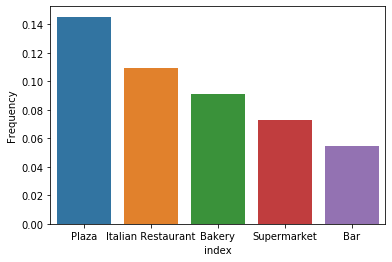

In [48]:
Cluster_0_top5 = Cluster_0_sum.head(5)
Cluster_0_top5.reset_index(inplace = True)
sns.barplot(x = 'index', y = 'Frequency', data = Cluster_0_top5)

## Cluster 1

In [35]:
Cluster_1 = brussels_merged.loc[brussels_merged['Cluster Labels'] == 1, brussels_merged.columns[[0] + list(
    range(5, brussels_merged.shape[1]))]].drop('Longitude', axis = 1)
Cluster_1

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Berchem-Sainte-Agathe,1,Greek Restaurant,Tram Station,Gym,Restaurant,Bar,Supermarket,Bus Stop,Burger Joint,Notary,Electronics Store


### 5 most popular venues

In [36]:
Cluster_1_sum = Cluster_1[['1st Most Common Venue',
           '2nd Most Common Venue',
           '3rd Most Common Venue',
           '4th Most Common Venue',
           '5th Most Common Venue']].apply(pd.value_counts).fillna(0)

Cluster_1_sum = Cluster_1_sum.sum(axis = 1).sort_values(ascending = False).to_frame()
Cluster_1_sum.columns = ['Sum']
Cluster_1_n_venues = 5 * len(Cluster_1.index.tolist())
Cluster_1_sum['Frequency'] = Cluster_1_sum['Sum'] / Cluster_1_n_venues

Cluster_1_sum.head(5)

,Sum,Frequency
Tram Station,1.0,0.2
Restaurant,1.0,0.2
Gym,1.0,0.2
Greek Restaurant,1.0,0.2
Bar,1.0,0.2


### Visualizing frequency of 5 most popular venues in Cluster 1

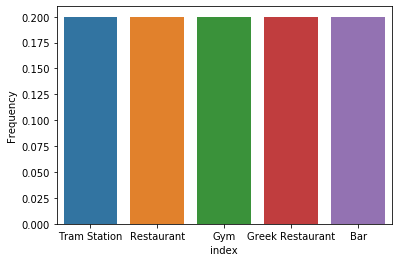

In [37]:
Cluster_1_top5 = Cluster_1_sum.head(5)
Cluster_1_top5.reset_index(inplace = True)
sns.barplot(x = 'index', y = 'Frequency', data = Cluster_1_top5)

## Cluster 2

In [38]:
Cluster_2 = brussels_merged.loc[brussels_merged['Cluster Labels'] == 2, brussels_merged.columns[[0] + list(
    range(5, brussels_merged.shape[1]))]].drop('Longitude', axis = 1)
Cluster_2

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bruxelles-Ville,2,Bar,Beer Bar,Chocolate Shop,Plaza,Thai Restaurant,Hotel,Bookstore,Sandwich Place,Coffee Shop,Burger Joint
6,Forest,2,Bar,Beer Bar,Chocolate Shop,Plaza,Thai Restaurant,Hotel,Bookstore,Sandwich Place,Coffee Shop,Burger Joint
11,Molenbeek-Saint-Jean,2,Bar,Plaza,French Restaurant,Yoga Studio,Hotel,Convenience Store,Seafood Restaurant,Belgian Restaurant,Supermarket,Theater
12,Saint-Gilles,2,Bar,Pizza Place,Brasserie,Coffee Shop,Italian Restaurant,Moroccan Restaurant,Portuguese Restaurant,Plaza,Wine Bar,Park


### 5 most popular venues

In [39]:
Cluster_2_sum = Cluster_2[['1st Most Common Venue',
           '2nd Most Common Venue',
           '3rd Most Common Venue',
           '4th Most Common Venue',
           '5th Most Common Venue']].apply(pd.value_counts).fillna(0)

Cluster_2_sum = Cluster_2_sum.sum(axis = 1).sort_values(ascending = False).to_frame()
Cluster_2_sum.columns = ['Sum']
Cluster_2_n_venues = 5 * len(Cluster_2.index.tolist())
Cluster_2_sum['Frequency'] = Cluster_2_sum['Sum'] / Cluster_2_n_venues

Cluster_2_sum.head(5)

,Sum,Frequency
Bar,4.0,0.20
Plaza,3.0,0.15
Thai Restaurant,2.0,0.10
Chocolate Shop,2.0,0.10
Beer Bar,2.0,0.10


### Visualizing frequency of 5 most popular venues in Cluster 2

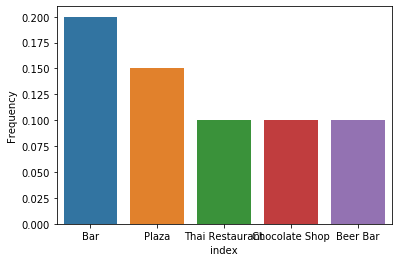

In [40]:
Cluster_2_top5 = Cluster_2_sum.head(5)
Cluster_2_top5.reset_index(inplace = True)
sns.barplot(x = 'index', y = 'Frequency', data = Cluster_2_top5)

## Cluster 3

In [41]:
Cluster_3 = brussels_merged.loc[brussels_merged['Cluster Labels'] == 3, brussels_merged.columns[[0] + list(
    range(5, brussels_merged.shape[1]))]].drop('Longitude', axis = 1)
Cluster_3

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Watermael-Boitsfort,3,Restaurant,Italian Restaurant,Park,Ice Cream Shop,Chinese Restaurant,French Restaurant,Gastropub,Indian Restaurant,Soccer Field,Bookstore


### 5 most popular venues

In [42]:
Cluster_3_sum = Cluster_3[['1st Most Common Venue',
           '2nd Most Common Venue',
           '3rd Most Common Venue',
           '4th Most Common Venue',
           '5th Most Common Venue']].apply(pd.value_counts).fillna(0)

Cluster_3_sum = Cluster_3_sum.sum(axis = 1).sort_values(ascending = False).to_frame()
Cluster_3_sum.columns = ['Sum']
Cluster_3_n_venues = 5 * len(Cluster_3.index.tolist())
Cluster_3_sum['Frequency'] = Cluster_3_sum['Sum'] / Cluster_3_n_venues

Cluster_3_sum.head(5)

,Sum,Frequency
Restaurant,1.0,0.2
Park,1.0,0.2
Italian Restaurant,1.0,0.2
Ice Cream Shop,1.0,0.2
Chinese Restaurant,1.0,0.2


### Visualizing frequency of 5 most popular venues in Cluster 3

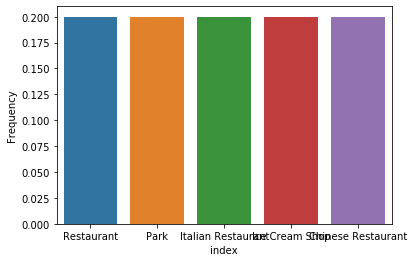

In [43]:
Cluster_3_top5 = Cluster_3_sum.head(5)
Cluster_3_top5.reset_index(inplace = True)
sns.barplot(x = 'index', y = 'Frequency', data = Cluster_3_top5)

## Cluster 4

In [44]:
Cluster_4 = brussels_merged.loc[brussels_merged['Cluster Labels'] == 4, brussels_merged.columns[[0] + list(
    range(5, brussels_merged.shape[1]))]].drop('Longitude', axis = 1)
Cluster_4

,Municipality,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Evere,4,Supermarket,Snack Place,Hotel,Brasserie,Sandwich Place,Bakery,Indian Restaurant,Restaurant,Sports Bar,Spa
10,Koekelberg,4,Supermarket,Bar,Park,Gym,Snack Place,Convenience Store,Metro Station,Tea Room,Bus Station,Sandwich Place


### 5 most popular venues

In [45]:
Cluster_4_sum = Cluster_4[['1st Most Common Venue',
           '2nd Most Common Venue',
           '3rd Most Common Venue',
           '4th Most Common Venue',
           '5th Most Common Venue']].apply(pd.value_counts).fillna(0)

Cluster_4_sum = Cluster_4_sum.sum(axis = 1).sort_values(ascending = False).to_frame()
Cluster_4_sum.columns = ['Sum']
Cluster_4_n_venues = 5 * len(Cluster_4.index.tolist())
Cluster_4_sum['Frequency'] = Cluster_4_sum['Sum'] / Cluster_4_n_venues

Cluster_4_sum.head(5)

,Sum,Frequency
Supermarket,2.0,0.2
Snack Place,2.0,0.2
Sandwich Place,1.0,0.1
Park,1.0,0.1
Hotel,1.0,0.1


### Visualizing frequency of 5 most popular venues in Cluster 4

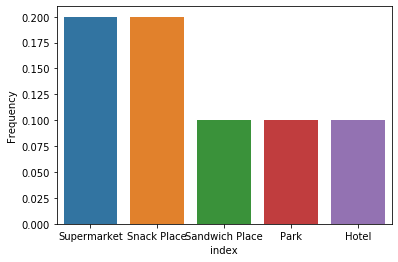

In [46]:
Cluster_4_top5 = Cluster_4_sum.head(5)
Cluster_4_top5.reset_index(inplace = True)
sns.barplot(x = 'index', y = 'Frequency', data = Cluster_4_top5)